# Define vector 3D class

In [6]:
import math
import numpy as np

class Vector3D:
    def __init__(self, initial_x = 0.0, initial_y = 0.0, initial_z = 0.0):
        self.x = initial_x
        self.y = initial_y
        self.z = initial_z
    
    def magnitude(self):
        return math.sqrt(self.x**2 + self.y**2 + self.z**2)
    
    def sqd_magnitude(self):
        return self.x**2 + self.y**2 + self.z**2
    
    # Operator overloading for adding two vecs  
    def __add__(self, v): 
        return Vector3D(self.x + v.x, self.y + v.y, self.z + v.z)
    
    def __mul__(self, scalar):
        return Vector3D(self.x*scalar, self.y*scalar, self.z*scalar)
    
    def __sub__(self, v):
        return Vector3D(self.x - v.x, self.y - v.y, self.z - v.z)
    
    def __eq__(self, other):
        if isinstance(other, Vector3D):
            return self.x == other.x and self.y == other.y and self.z == other.z
    
    #printing overloaded
    def __str__(self): 
        return "x=" + str(self.x) + ", y=" + str(self.y) + ", z=" + str(self.z)
    
    def apply_periodic_boundries(self, lx, ly, lz):
        # periodic boundary
        if (self.x > lx/2.0):
            self.x = self.x - lx
        if (self.x < -lx/2.0):
            self.x = self.x + lx
        if (self.y > ly/2.0):
            self.y = self.y - ly
        if (self.y < -ly/2.0):
            self.y = self.y + ly
        if (self.z > lz/2.0):
            self.z = self.z - lz
        if (self.z < -lz/2.0):
            self.z = self.z + lz
        

# Define Particle class

In [30]:
import math

class Particle:
    
    def __init__(self, id_value=0, diameter = 0.0, initial_m = 0.0,  initial_position = Vector3D(0.0, 0.0, 0.0), initial_velocity = Vector3D(0.0, 0.0, 0.0), initial_lx = 0.0, initial_ly = 0.0, initial_lz = 0.0):
        self.id = id_value       
        self.m = initial_m
        self.d = diameter
        self.position = initial_position
        self.velocity = initial_velocity
        self.lx = initial_lx;
        self.ly = initial_ly;
        self.lz = initial_lz;
        self.pe = 0.0
        self.ke = 0.0
        self.force = Vector3D(0.0, 0.0, 0.0)
        
        
    def volume(self):
        self.volume = (4.0/3.0) * math.pi * ((self.d/2.0)**3)
        
    #position updated to a full time-step 
    def update_position(self, dt, box):
        self.position = self.position + (self.velocity * dt)
        # periodic boundary
        self.position.apply_periodic_boundries(box.lx, box.ly, box.lz)     
            
    #velocity updated to a half time-step     
    def update_velocity(self, dt):
        self.velocity = self.velocity + (self.force * ( 0.5 * dt / self.m))
        
    def kinetic_energy(self):
        self.ke = 0.5 * self.m * (self.velocity.magnitude()**2)
            

# Define Box class

In [29]:
import random
class Box:
    
    def __init__(self, initial_position = Vector3D(0.0, 0.0, 0.0), m_lx = 10.0, m_ly = 10.0, m_lz = 10.0):
        self.position = initial_position #origin point of the simulation box 
        self.lx = m_lx                        #length of the box in x direction
        self.ly = m_ly                        #length of the box in y direction
        self.lz = m_lz                        #length of the box in z direction
        
        
    def put_ljatoms_inside(self, number_ljatom=0, ljatom_diameter=0.0, ljatom_mass=0.0, density=0.0):
        self.ljatom_diameter=ljatom_diameter
        #initialize the positions of the particles on a lattice (not randomly)
        #out_initialize_position = open("many_particle_data/ip.lammpstrj", "w")
        print("# of atoms created in the box = {}".format(number_ljatom))
        a = 1
        print("# lattice spacing (based on crystal of closest packing) is = {}".format(a))
        
        num_atoms_linear = int(math.ceil(math.pow((float(number_ljatom)),1.0/3.0)))
        print("# in each direction, about {} atoms".format(num_atoms_linear))
        
        self.ljatom = []
        # initial ion positions
        for i in range(num_atoms_linear):
            for j in range(num_atoms_linear):
                for k in range(num_atoms_linear):
                    # stop if atoms created are equal to the requested number
                    if len(self.ljatom) < number_ljatom:
                        x = (-self.lx/2) + i*a
                        y = (-self.ly/2) + j*a 
                        z = (-self.lz/2) + k*a
                        if (z >= (self.lz/2.0 - a/2.0) or y >= (self.ly/2.0 - a/2.0 ) or x >= (self.lx/2.0 - a/2.0)):
                            continue
                        position = Vector3D(x,y,z)
                        velocity = Vector3D(0.0,0.0,0.0)
                        fresh_atom = Particle(len(self.ljatom)+1, self.ljatom_diameter, ljatom_mass, position, velocity, self.lx, self.ly, self.lz)
                        self.ljatom.append(fresh_atom)
        
        #out_initialize_position.close()
  
        #make a snapshot movie of initial positions of the particles
        self.make_movie(num=0, file_name="final_ip.lammpstrj")

        return len(self.ljatom)

    def put_ljatoms_inside_random(self, number_ljatom=0, ljatom_diameter=0.0, ljatom_mass=0.0, density=0.0, edge_length=0.0):
        self.ljatom_diameter=ljatom_diameter
        #fake_diameter = 0.01
        #initialize the positions of the particles on a lattice (not randomly)
        #out_initialize_position = open("many_particle_data/ip.lammpstrj", "w")
        print("# of atoms created in the box = {}".format(number_ljatom))
        a = 1.0
        print("# lattice spacing (based on crystal of closest packing) is = {}".format(a))
        try_count_limit = 1000000*number_ljatom
        self.ljatom = []
        # initial ion positions
        try_count = 0
        while len(self.ljatom) < number_ljatom and try_count < try_count_limit:
            
            xx = np.random.uniform(-edge_length/2 , edge_length/2 ,1)[0]
            yy = np.random.uniform(-edge_length/2 , edge_length/2 ,1)[0]
            zz = np.random.uniform(-edge_length/2 , edge_length/2 ,1)[0]
            
            position = Vector3D(xx,yy,zz)
            sanity_check = 0
        
            for i in range(0, len(self.ljatom),1):
                if abs(self.ljatom[i].position.magnitude() - position.magnitude()) >  self.ljatom_diameter:
                    sanity_check += 1 
                else:
                    break
            
            if len(self.ljatom) == sanity_check:
                velocity = Vector3D(0.0,0.0,0.0)
                fresh_atom = Particle(len(self.ljatom)+1, self.ljatom_diameter, ljatom_mass, position, velocity, self.lx, self.ly, self.lz)
                self.ljatom.append(fresh_atom)
                print(position)
                print(len(self.ljatom))
        
            try_count += 1
            
            if try_count == try_count_limit:
                print("Cant put ions inside the box ")
                print(try_count)
                self.ljatom = []
                return 0
            
        #out_initialize_position.close()
  
        #make a snapshot movie of initial positions of the particles
        self.make_movie(num=0, file_name="final_ip.lammpstrj")

        return len(self.ljatom)    
    
    
    #make movie
    def make_movie(self, num=0, file_name = ''):
        if num==0:
            outdump = open("many_particle_data/"+file_name, "w")
        else:
            outdump = open("many_particle_data/"+file_name, "a")
        outdump.write("ITEM: TIMESTEP\n")
        outdump.write("{}\n".format(num - 1))
        outdump.write("ITEM: NUMBER OF ATOMS\n")
        outdump.write("{}\n".format(len(self.ljatom)))
        outdump.write("ITEM: BOX BOUNDS\n")
        outdump.write("{}\t{}\n".format(-0.5*self.lx, 0.5*self.lx))
        outdump.write("{}\t{}\n".format(-0.5*self.ly, 0.5*self.ly))
        outdump.write("{}\t{}\n".format(-0.5*self.lz, 0.5*self.lz))
        outdump.write("ITEM: ATOMS index type x y z v\n")
        for i in range(len(self.ljatom)):
            outdump.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(i+1, "1", self.ljatom[i].position.x, self.ljatom[i].position.y, self.ljatom[i].position.z, self.ljatom[i].velocity.magnitude())) 
        outdump.close()
      
    #Velocity init: Currenly zero
    def initialize_particle_velocities(self):
        print("Velocity init")
        
    #Force computation
    def update_forces(self, dcut=0.0):
        self.dcut = dcut
        elj = 2.0
        dcut2 = self.dcut*self.dcut
        d = 1 #recall that we are working in reduced units where the unit of length is the diameter of the particle
        d2 = d*d
        d6 = d2 * d2 * d2
        d12 = d6 * d6
        d_cut_off = dcut2 * d2
        
        for i in range(len(self.ljatom)):
            flj = Vector3D(0.0,0.0,0.0)
            for j in range(len(self.ljatom)):
                if (j == i):
                    continue
                r_vec = self.ljatom[i].position - self.ljatom[j].position
                #Add periodic boundries
                r_vec.apply_periodic_boundries(self.lx, self.ly, self.lz)
                #r = r_vec.magnitude()
                r2 = r_vec.sqd_magnitude()
                #Cut off check
                if (r2 < d_cut_off):
                    r6 = r2 * r2 * r2
                    r12 = r6 * r6
                    flj += ( r_vec * ( 48 * elj * (  (d12 / r12)  - 0.5 *  (d6 / r6) ) * ( 1 / r2 ) ) )       
            self.ljatom[i].force = flj 
            
    #Force computation
    def update_forces_with_dummy(self, dcut=0.0):
        self.dcut = dcut
        elj = 2.0
        dcut2 = self.dcut*self.dcut
        d = 1 #recall that we are working in reduced units where the unit of length is the diameter of the particle
        d2 = d*d
        d6 = d2 * d2 * d2
        d12 = d6 * d6
        d_cut_off = dcut2 * d2
        
        for i in range(len(self.ljatom)):
            flj = Vector3D(0.0,0.0,0.0)
            for j in range(len(self.ljatom)):
                if (j == i):
                    continue
                r_vec = self.ljatom[i].position - self.ljatom[j].position
                #Add periodic boundries
                r_vec.apply_periodic_boundries(self.lx, self.ly, self.lz)
                #r = r_vec.magnitude()
                r2 = r_vec.sqd_magnitude()
                #Cut off check
                if (r2 < d_cut_off):
                    r6 = r2 * r2 * r2
                    r12 = r6 * r6
                    flj += ( r_vec * ( 48 * elj * (  (d12 / r12)  - 0.5 *  (d6 / r6) ) * ( 1 / r2 ) ) )       
            self.ljatom[i].force = flj  
            
            
        for i in range(len(self.ljatom)):
            flj = Vector3D(0.0,0.0,0.0)
            for j in range(len(self.ljatom)):
                if (j == i):
                    continue
                r_vec = self.ljatom[i].position - self.ljatom[j].position
                #Add periodic boundries
                r_vec.apply_periodic_boundries(self.lx, self.ly, self.lz)
                #r = r_vec.magnitude()
                r2 = r_vec.sqd_magnitude()
                #Cut off check
                if (r2 < d_cut_off):
                    r6 = r2 * r2 * r2
                    r12 = r6 * r6
                    flj += ( r_vec * ( 48 * elj * (  (d12 / r12)  - 0.5 *  (d6 / r6) ) * ( 1 / r2 ) ) )       
            self.ljatom[i].force = flj  
 
    #Potential Energy computation
    def update_p_energies(self, dcut=0.0):
        self.dcut = dcut
        elj = 2.0
        dcut2 = self.dcut  * self.dcut
        dcut6 = dcut2 * dcut2 * dcut2
        dcut12 = dcut6 * dcut6
        d = 1 #recall that we are working in reduced units where the unit of length is the diameter of the particle
        d2 = d * d
        d6 = d2 * d2 * d2
        d_cut_off = dcut2 * d2
        
        energy_shift = 4*elj*((1/dcut12) - (1/dcut6))
        total_lj_atom_atom = 0.0
        
        for i in range(len(self.ljatom)):
            uljpair = 0.0
            for j in range(len(self.ljatom)):
                if (j == i):
                    continue
                r_vec = self.ljatom[i].position - self.ljatom[j].position
                #Add periodic boundries
                r_vec.apply_periodic_boundries( self.lx, self.ly, self.lz)
                r2 = r_vec.sqd_magnitude()
                #Cut off check
                if (r2 < d_cut_off):
                    r6 = r2 * r2 * r2
                    uljpair +=  4 * elj * (d6 / r6) * ( ( d6 / r6 ) - 1 ) - energy_shift
                    
            self.ljatom[i].pe = uljpair
            total_lj_atom_atom += uljpair
        total_lj_atom_atom = 0.5*total_lj_atom_atom    
        return total_lj_atom_atom

    #kinatic Energy computation
    def update_k_energies(self):
        total_ke_atom = 0.0
        for i in range(len(self.ljatom)):
            self.ljatom[i].kinetic_energy()
            total_ke_atom += self.ljatom[i].ke
        return total_ke_atom
    
    #update half time velocity
    def update_velocity(self, delta_t):
        for i in range(len(self.ljatom)):
            self.ljatom[i].update_velocity(delta_t)
    
    #update full time velocity
    def update_position(self, delta_t):            
        for i in range(len(self.ljatom)):
            self.ljatom[i].update_position(delta_t)    

# Other functions

In [26]:
#display progress
def progressBar(fraction_completed):
    val = int(fraction_completed * 100)
    lpad = int(fraction_completed * 60)
    sys.stdout.write("\r[%-60s] %d%%" % ('='*lpad, val))

# Velocity verlet Function

In [34]:
import math
import time
import sys
import os
import shutil
import time

def velocity_verlet(ljatom_density=None, number_ljatom=None):
    #we begin with some fundamental numbers/physical constants
    pi = 3.141593 #Pi
    kB = 1.38e-23 #Joules per Kelvin
    mol = 6.0e23 #Avogadro number
    
    #reduced units
    unitlength = 0.3405e-9      # m; unit of length is these many meters (diameter of a typical atom)
    unitenergy = 119.8 * kB     #Joules; unit of energy is these many Joules (typical interaction strength)
    unitmass = 0.03994 / mol    #kg; unit of mass (mass of a typical atom)
    unittime = math.sqrt(unitmass * unitlength * unitlength / unitenergy)    #Unit of time
    unittemperature = unitenergy/kB       #unit of temperature 
    
    #essential parameters needed for particles in a box simulation
    #**********************
    #ljatom_density=0.0          #this is taken in as mass density (in reduced units)
    #number_ljatom=0             #total number of particles in your system
    ljatom_diameter=0.0 
    ljatom_mass=0.0 
    bx=0.0                      #box edge lengths
    by=0.0
    bz=0.0     
    temperature=0.0 
    #dcut=0.0                    #cutoff distance for potential in reduced units
    #**********************

    #shutil.rmtree('many_particle_data',True)
    if not os.path.exists('many_particle_data'):
        os.makedirs('many_particle_data')
    
    print("Program starts")
    print("units of length, energy, mass are given near the top of the main function")
    print("unit of length is {} meters".format(unitlength))
    print("unit of mass is {} kilograms".format(unitmass))
    print("unit of energy is {} Joules".format(unitenergy))
    print("unit of time is {} seconds".format(unittime))
    
    # inputs 1
    #this is taken in as mass density (in reduced units)
    if ljatom_density is None:
        print("enter density (in LJ reduced units: recall unit of length is diameter of your lj particle); tested for rho = 0.8442  ")
        time.sleep(0.1) # This sleep is not needed, just added to get input box below the print statements
        ljatom_density = float(input())
    # inputs 2
    #total number of particles in your system
    if number_ljatom is None:
        print("enter total number of ljatoms (108 is a typical value; tested for this value) ")
        time.sleep(0.1)
        number_ljatom = float(input())
    dcut=2.5
    ljatom_diameter = 1.0         #in reduced units
    ljatom_mass = 1.0
    
    edge_length = math.pow(number_ljatom/ljatom_density,1.0/3.0)
    edge_length_ = edge_length
    #edge_length_ = 20
    print("edge length calculated to be: {}".format(edge_length))
    
    bx = edge_length_
    by = edge_length_
    bz = edge_length_
    #place where the action happens, periodic boundaries
    simulation_box = Box(Vector3D(0.0, 0.0, 0.0), bx, by, bz)
    ljatom_size = simulation_box.put_ljatoms_inside(number_ljatom, ljatom_diameter, ljatom_mass, ljatom_density)
    
    multi = 4
    simulation_box.lx = edge_length_*multi                        #length of the box in x direction
    simulation_box.ly = edge_length_*multi                        #length of the box in y direction
    simulation_box.lz = edge_length_*multi
    
    
    #ljatom_size = simulation_box.put_ljatoms_inside_random(number_ljatom, ljatom_diameter, ljatom_mass, ljatom_density, 4.0)
    
    #output to screen the parameters of the problem
    print("Box dimensions x = {} | y = {} | z = {} ".format(simulation_box.lx, simulation_box.ly, simulation_box.lz))
    print("Number of LJ atoms inside the box = {} ".format(ljatom_size))
    print("LJ atom diameter (in SI units; meter) = {} ".format(ljatom_diameter*unitlength))
    print("LJ atom mass (in SI units; kg) = {} ".format(ljatom_mass*unitmass))
    print("cut off distance (in reduced units) = {} ".format(dcut))
    
    #simulation_box.initialize_particle_velocities()
    #Inital force computation
    simulation_box.update_forces(dcut)
    
    totaltime = 20
    #number of time discretizations (slices)
    steps = 20000
    #the code deterimes the time-step delta_t. choose steps carefully, make sure you have a fine discretization
    delta_t = totaltime/steps
    print("timestep (reduced units) = {}".format(delta_t))
    print("timestep (in SI units; second) = {}".format(delta_t*unittime))
    print("total simulation time (in real units) = {}".format(totaltime*unittime))
    
    movie_file_name = "propagation.lammpstrj"
    #energy_filename = "energy_rho={}_N={}.out".format(ljatom_density, number_ljatom)
    energy_filename = "energy.dat"
    
    #Initial energies
    totalpe = simulation_box.update_p_energies(dcut)  
    totalke = simulation_box.update_k_energies()
    
    with open("many_particle_data/"+energy_filename, "w") as output_energy:
        output_energy.write("{}\t{}\t{}\t{}\n".format(0, totalke/ljatom_size, totalpe/ljatom_size, (totalke+totalpe)/ljatom_size)) 
  
    print("initial total energy per lj particle is = {}".format( (totalke+totalpe)/ljatom_size))
    
    #Initial movie dump
    simulation_box.make_movie(num=0, file_name="propagation.lammpstrj")

    movie_frequency = 100
    average_pe = 0.0
    average_ke = 0.0
    data_collect_frequency = 1000
    samples = 0;
    hit_eqm = 3000               #this is your choice of where you think the system hit equilibrium
    
    #Molecular Dynamics
    print("progress...")

    for num in range(1, steps+1):
        #velocity-Verlet
        #update velocity half timestep
        simulation_box.update_velocity(delta_t)
        #update position full timestep
        simulation_box.update_position(delta_t, simulation_box)
        #expensive step  
        simulation_box.update_forces(dcut) 
        totalpe = simulation_box.update_p_energies(dcut)
        #update other half velocity
        simulation_box.update_velocity(delta_t)
        totalke = simulation_box.update_k_energies()

      
        #calling a movie function to get a movie of the simulation
        if (num%movie_frequency == 0):
            simulation_box.make_movie(num=num, file_name=movie_file_name)
            
        #outputting the energy to make sure simulation can be trusted
        if (num%data_collect_frequency == 0):
            with open("many_particle_data/"+energy_filename, "a") as output_energy:
                output_energy.write("{}\t{}\t{}\t{}\n".format(num, totalke/ljatom_size, totalpe/ljatom_size, (totalke+totalpe)/ljatom_size)) 

        if (num > hit_eqm and num%data_collect_frequency == 0):
            average_pe += totalpe
            average_ke += totalke
            samples += 1
            
        if num%100==0:
            fraction_completed = num/steps
            progressBar(fraction_completed)
        
    print("")
    print("average pe per particle is = {}".format((average_pe/samples)/ljatom_size))
    print("average ke per particle is = {}".format((average_ke/samples)/ljatom_size))
    print("average T per particle is = {}".format(2*(average_ke/samples)/(3*number_ljatom))) 
    print("Simulation is over.")

# Run the code

In [36]:
start = time.time()
# Run the program
#name__ = (0.8442, 108)
#velocity_verlet(*name__)
velocity_verlet(ljatom_density=0.5, number_ljatom=8)

end = time.time()
print("Time: "+str(end - start))

Program starts
units of length, energy, mass are given near the top of the main function
unit of length is 3.405e-10 meters
unit of mass is 6.656666666666667e-26 kilograms
unit of energy is 1.65324e-21 Joules
unit of time is 2.1606159067248715e-12 seconds
edge length calculated to be: 2.5198420997897464
# of atoms created in the box = 8
# lattice spacing (based on crystal of closest packing) is = 1
# in each direction, about 2 atoms
Box dimensions x = 10.079368399158986 | y = 10.079368399158986 | z = 10.079368399158986 
Number of LJ atoms inside the box = 8 
LJ atom diameter (in SI units; meter) = 3.405e-10 
LJ atom mass (in SI units; kg) = 6.656666666666667e-26 
cut off distance (in reduced units) = 2.5 
timestep (reduced units) = 0.001
timestep (in SI units; second) = 2.1606159067248715e-15
total simulation time (in real units) = 4.321231813449743e-11
initial total energy per lj particle is = -1.3409429417462169
progress...
[===========================================================

# Plot the energy graphs

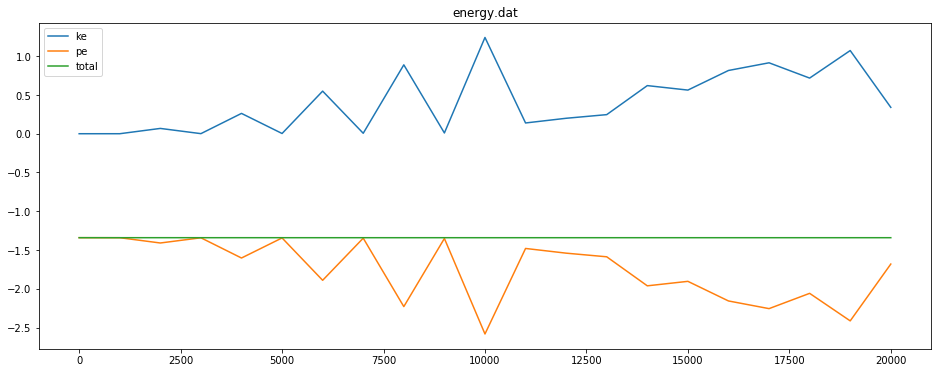

In [37]:
# Visualize the data
name__ = (0.8442, 3)
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline


import numpy as np
#file_name = 'energy_rho='+str(name__[0])+'_N='+str(name__[1])+'.out'
file_name = 'energy.dat'
result_file = np.loadtxt("many_particle_data/"+file_name)

fig=plt.figure(figsize=(16, 6))
plt.title(file_name)
plt.plot(result_file[:,0],result_file[:,1], label='ke')
plt.plot(result_file[:,0],result_file[:,2], label='pe')
plt.plot(result_file[:,0],result_file[:,3], label='total')

plt.legend()

# Play the movie

In [8]:
from python_src.dump import dump
from python_src.xyz import xyz
from python_src.svg import svg
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd
from IPython.display import HTML
%matplotlib notebook
%matplotlib notebook

class Particle_viz:
    def __init__(self, movie_file_name = None):
    
        self.data = dump(movie_file_name)
        self.data.map(1,"id")
        self.time_frames = self.data.time()
        #selecting last index from sorted time frames
        time_value = self.time_frames[-1]
        time_index = self.data.findtime(time_value)
        last_snap_shot = self.data.viz(time_index)

        self.box_x_lim = last_snap_shot[1][0::3]
        self.box_y_lim = last_snap_shot[1][1::3]
        self.box_z_lim = last_snap_shot[1][2::3]

        self.all_data_frames = {}
        for t_ in self.time_frames:
            time_index = self.data.findtime(t_)
            snap_shot = np.array(self.data.viz(time_index)[2])
            self.all_data_frames[t_] = snap_shot[:,2:5]


        #%matplotlib inline
        #figsize=(8, 8)
        self.fig = plt.figure(num='MD simulation output', figsize=(9, 8))
        self.ax = self.fig.add_subplot(111, projection='3d')
        #self.fig.suptitle('3D Test', fontsize=16)
        self.title = self.ax.set_title('Frame=-1')

        # Setting the axes properties
        self.ax.set_xlim3d(self.box_x_lim)
        self.ax.set_xlabel('X')

        self.ax.set_ylim3d(self.box_y_lim)
        self.ax.set_ylabel('Y')

        self.ax.set_zlim3d(self.box_z_lim)
        self.ax.set_zlabel('Z')

        #self.ax.set_xticklabels([])
        #self.ax.set_xticks([])
        #self.ax.set_yticklabels([])
        #self.ax.set_yticks([])
        #self.ax.set_zticklabels([])
        #self.ax.set_zticks([])
    
    def update_graph(self, num):
        data_frame_=self.all_data_frames[self.time_frames[num]]
        self.graph.set_data (data_frame_[:,0],data_frame_[:,1])
        self.graph.set_3d_properties(data_frame_[:,2])
        self.title.set_text('Frame={}'.format(self.time_frames[num]))
        return self.title, self.graph, 
    
    def start(self):
        self.graph, = self.ax.plot(self.all_data_frames[self.time_frames[0]][:,1], self.all_data_frames[self.time_frames[0]][:,2], self.all_data_frames[self.time_frames[0]][:,0], 
                 c='r', marker='o',  linestyle="", markersize=10)
        
        # Creating the Animation object
        self.animation = matplotlib.animation.FuncAnimation(fig=self.fig, func=self.update_graph, frames=len(self.time_frames),
                              interval=50, blit=True)
        #self.ax.plt.show()
        #animation_.save('matplot003.gif', writer='imagemagick')
        #animation_.save('myvideo.mp4', codec='h264')
        #HTML(animation_.to_html5_video())
        

<IPython.core.display.Javascript object>


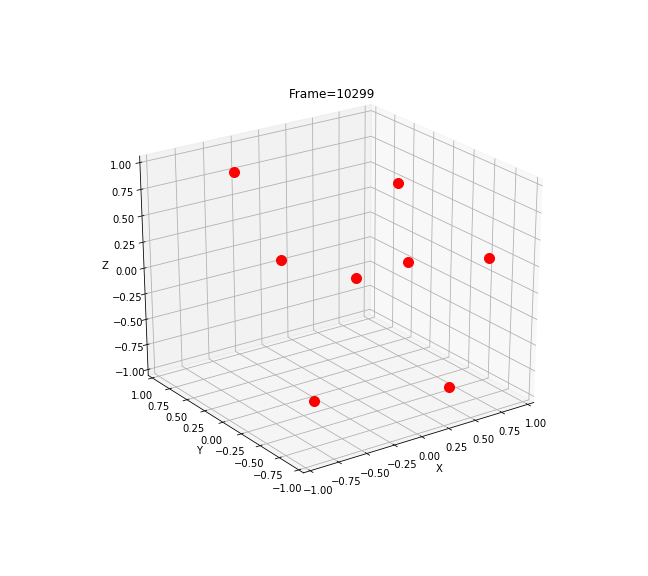

In [9]:
viz_sim = Particle_viz(movie_file_name = "many_particle_data/propagation.lammpstrj")
viz_sim.start()
#viz_simanimation.save('matplot003.gif', writer='imagemagick')
#viz_simanimation.save('myvideo.mp4', codec='h264')
#HTML(viz_sim.animation.to_html5_video())